In [4]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
from typing import Optional

import numpy as np
import torch
import tqdm
from tensordict.nn import TensorDictModule
from tensordict.tensordict import TensorDict, TensorDictBase
from torch import nn

from torchrl.data import BoundedTensorSpec, CompositeSpec, UnboundedContinuousTensorSpec
from torchrl.envs import (
    CatTensors,
    EnvBase,
    Transform,
    TransformedEnv,
    UnsqueezeTransform,
)
from torchrl.envs.transforms.transforms import _apply_to_composite
from torchrl.envs.utils import check_env_specs, step_mdp

import random
from pytorch3d import transforms
import math
from linguamechanica.kinematics import DifferentiableOpenChainMechanism
from linguamechanica.kinematics import UrdfRobotLibrary

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
error_done_threshold = 1e-3
weights = torch.Tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda()
urdf_robot = UrdfRobotLibrary.dobot_cr5()
chain_index = -1#3
used_open_chain = urdf_robot.extract_open_chains(0.3)[chain_index].to(weights.device)
thetas_count = used_open_chain.screws.shape[0]
pose_count = 6
on_manifold_count = (9 * 2) + ( 2 * thetas_count)
batch_size = 1024

In [6]:
thetas = torch.Tensor([[0.0],[0.0],[1.5]]).cuda()
transformation = used_open_chain.forward_transformation(
    thetas
)
pose = transforms.se3_log_map(transformation.get_matrix())
print(pose)
target_thetas = torch.Tensor([[1.0],[0.0],[0.5]]).cuda()
target_transformation = used_open_chain.forward_transformation(
    target_thetas
)
target_pose = transforms.se3_log_map(target_transformation.get_matrix())
print(target_pose)
used_open_chain = used_open_chain.to(thetas.device)

tensor([[ 8.9191e-01, -6.4650e-01,  6.4650e-01,  4.0799e-06, -2.2214e+00,
          2.2214e+00],
        [ 8.9191e-01, -6.4650e-01,  6.4650e-01,  4.0799e-06, -2.2214e+00,
          2.2214e+00],
        [ 6.5409e-01,  1.5070e-01, -2.5170e-01, -2.3000e+00,  2.2827e+00,
         -3.1305e-01]], device='cuda:0')
tensor([[-4.1440e-01, -4.1333e-01,  7.1470e-01,  1.3417e+00, -6.6351e-01,
          7.5451e-01],
        [ 8.9191e-01, -6.4650e-01,  6.4650e-01,  4.0799e-06, -2.2214e+00,
          2.2214e+00],
        [-6.2325e-01, -3.5645e-01,  7.3428e-01,  7.2195e-01,  8.1363e-01,
         -5.5225e-01]], device='cuda:0')


In [7]:
#print("!!!!!!!!!!!!!!!!!!!!!")
#print("thetas", thetas)
#print("target_pose", target_pose.shape)
#print("target_pose", target_pose)
#print("!!!!!!!!!!!!!!!!!!!!!")

In [8]:
def compute_error_pose(open_chain, thetas, target_pose):
    current_transformation = open_chain.forward_transformation(thetas)
    target_transformation = transforms.se3_exp_map(target_pose)
    current_trans_to_target = current_transformation.compose(
        transforms.Transform3d(matrix=target_transformation).inverse()
    )
    current_trans_to_target = current_trans_to_target.to(thetas.device).get_matrix()
    error_pose = transforms.se3_log_map(current_trans_to_target)
    return error_pose

compute_error_pose(used_open_chain, thetas, target_pose)

def compute_reward(thetas, target_pose, weights, error_done_threshold, open_chain):
    if len(thetas.shape) == 1:
        thetas = thetas.unsqueeze(0)
    if len(target_pose.shape) == 1:
        target_pose = target_pose.unsqueeze(0)
    open_chain = open_chain.to(thetas.device)
    error_pose = compute_error_pose(
        open_chain, thetas, target_pose
    )
    weights = weights.to(thetas.device)
    pose_error = DifferentiableOpenChainMechanism.compute_weighted_error(
        error_pose, weights
    )
    done = pose_error < error_done_threshold
    reward = - pose_error
    return reward, done

In [9]:
angles = torch.Tensor([0.1, -0.1, 0.2, -0.2])
angles_sin = angles.sin()
angles_cos = angles.cos()
torch.atan2(angles_sin, angles_cos) - angles

tensor([0., 0., 0., 0.])

In [27]:
def _step(self, tensordict):
    thetas = torch.atan2(tensordict["thetas_sin"], tensordict["thetas_cos"])
    theta_deltas = tensordict["action"]    
    #print("thetas", thetas.shape)
    #print("theta_deltas", theta_deltas.shape)
    theta_deltas_sin, theta_deltas_cos = None, None
    #print("len(theta_deltas.shape)", len(theta_deltas.shape))
    if len(theta_deltas.shape) == 3:
        theta_deltas_sin = theta_deltas[:, :, 0]
        theta_deltas_cos = theta_deltas[:, :, 1]
    else:
        theta_deltas_sin = theta_deltas[0]
        theta_deltas_cos = theta_deltas[1]
    theta_deltas = torch.atan2(theta_deltas_sin, theta_deltas_cos)
    #print("theta_deltas", theta_deltas.shape, theta_deltas_sin.shape, theta_deltas_cos.shape)
    
    #print("theta_deltas", theta_deltas.shape)
    #print("thetas", thetas.shape)
    #max_theta_deltas = tensordict["params", "max_theta_deltas"]
    #print(thetas.shape, theta_deltas.shape)
    new_thetas = thetas + theta_deltas
    #new_thetas = new_thetas.clamp(-max_theta_deltas, max_theta_deltas)
    target_pose = tensordict["target_pose"]
    #print("target_pose in _step", target_pose)
    #print("STEP", f"Target: {target_pose}", f"Thetas: {thetas}", f"New Thetas: {new_thetas}")
    #TODO: I have no idea if this is a good idea or not
    #new_thetas = force_parameters_within_bounds(new_thetas)
    #print("----------------------------")
    #print("new_thetas.shape", new_thetas.shape)
    #print("target_pose", target_pose)
    #print("weights.shape", weights.shape)
    #print("----------------------------")
    reward, done = compute_reward(new_thetas, target_pose, weights, error_done_threshold, self.open_chain)
    done = torch.zeros_like(reward, dtype=torch.bool)
    out = TensorDict(
        {
            "next": {
                "thetas_sin": new_thetas.sin(),
                "thetas_cos": new_thetas.cos(),
                "target_pose": target_pose,
                "params": tensordict["params"],
                "reward": reward,
                "done": done,
            }
        },
        tensordict.shape,
    )
    return out
def uniformly_sample_parameters_within_constraints(open_chain, batch_size):
    samples = []
    for sample_idx in range(batch_size):
        coordinates = []
        for i in range(len(open_chain.joint_limits)):
            # TODO: check if unconstrained works
            coordinates.append(
                random.uniform(
                    open_chain.joint_limits[i][0],
                    open_chain.joint_limits[i][1],
                )
            )
        samples.append(torch.Tensor(coordinates).unsqueeze(0))
    return torch.cat(samples, 0)
def generate_random_target_pose(target_thetas, open_chain):
    if len(target_thetas.shape) == 1:
        target_thetas = target_thetas.unsqueeze(0)
    open_chain = open_chain.to(target_thetas.device)
    target_transformation = open_chain.forward_transformation(
        target_thetas
    )
    target_pose = transforms.se3_log_map(
        target_transformation.get_matrix()
    )
    if target_thetas.shape[0] == 1:
        target_thetas = target_thetas.squeeze(0)
    #print("generate_random_target_pose", target_pose)
    return target_pose
def _reset(self, tensordict):
    if tensordict is None or tensordict.is_empty():
        # if no tensordict is passed, we generate a single set of hyperparameters
        # Otherwise, we assume that the input tensordict contains all the relevant
        # parameters to get started.
        tensordict = self.gen_params(batch_size=self.batch_size)
    batch_size = 1 if len(tensordict.shape) == 0 else tensordict.shape[0]
    thetas = uniformly_sample_parameters_within_constraints(self.open_chain, batch_size).to(device=self.device)
    if batch_size == 1:
        thetas = thetas.squeeze(0)    
    #thetas = force_parameters_within_bounds(thetas)
    #TODO: randommize this better
    target_thetas = thetas + ((torch.randn(thetas.shape).to(self.device)) * 0.10)
    #target_thetas = force_parameters_within_bounds(target_thetas)
    target_pose   = generate_random_target_pose(target_thetas, self.open_chain)
    if batch_size == 1:
        target_pose = target_pose.squeeze(0)
    #print("target_pose.shape", target_pose.shape)
    out = TensorDict(
        {
            "thetas_sin": thetas.sin(),
            "thetas_cos": thetas.cos(),
            "target_pose": target_pose,
            "params": tensordict["params"],
        },
        batch_size=tensordict.shape,
    )
    return out
def _make_spec(self, td_params):
    # Under the hood, this will populate self.output_spec["observation"]
    self.observation_spec = CompositeSpec(
        thetas_sin=BoundedTensorSpec(
            minimum=-torch.ones(thetas_count),# * torch.pi,
            maximum= torch.ones(thetas_count),# * torch.pi,
            shape=(thetas_count),
            dtype=torch.float32,
        ),
        thetas_cos=BoundedTensorSpec(
            minimum=-torch.ones(thetas_count),# * torch.pi,
            maximum= torch.ones(thetas_count),# * torch.pi,
            shape=(thetas_count),
            dtype=torch.float32,
        ),
        #TODO: bounds are wrong. They need to be the ones in the robot constraints
        target_pose=BoundedTensorSpec(
            minimum=-torch.ones(pose_count) * 10000.0,
            maximum= torch.ones(pose_count) * 10000.0,
            shape=(pose_count),
            dtype=torch.float32,
        ),
        # we need to add the "params" to the observation specs, as we want
        # to pass it at each step during a rollout
        params=make_composite_from_td(td_params["params"]),
        shape=(),
    )
    # since the environment is stateless, we expect the previous output as input.
    # For this, EnvBase expects some state_spec to be available
    self.state_spec = self.observation_spec.clone()
    # action-spec will be automatically wrapped in input_spec when
    # `self.action_spec = spec` will be called supported
    #TODO: bounds are wrong
    self.action_spec = BoundedTensorSpec(
        minimum=-torch.ones(thetas_count, thetas_count),# * 100000.0,
        maximum=+torch.ones(thetas_count, thetas_count),# * 100000.0,
        shape=(thetas_count, thetas_count),
        dtype=torch.float32,
    )
    self.reward_spec = UnboundedContinuousTensorSpec(shape=(*td_params.shape, 1))


def make_composite_from_td(td):
    # custom funtion to convert a tensordict in a similar spec structure
    # of unbounded values.
    composite = CompositeSpec(
        {
            key: make_composite_from_td(tensor)
            if isinstance(tensor, TensorDictBase)
            else UnboundedContinuousTensorSpec(
                dtype=tensor.dtype, device=tensor.device, shape=tensor.shape
            )
            for key, tensor in td.items()
        },
        shape=td.shape,
    )
    return composite

def _set_seed(self, seed: Optional[int]):
    rng = torch.manual_seed(seed)
    self.rng = rng
def gen_params(batch_size=None) -> TensorDictBase:
    if batch_size is None:
        batch_size = []
    td = TensorDict(
        {
            "params": TensorDict(
                {
                    "max_theta_deltas": torch.ones(thetas_count) * torch.pi,
                },
                [],
            )
        },
        [],
    )
    if batch_size:
        td = td.expand(batch_size).contiguous()
    return td
class InverseKinematicsEnv(EnvBase):
    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 30,
    }
    batch_locked = False

    def __init__(self, open_chain=None, td_params=None, seed=None, device="cuda:0"):
        super().__init__()
        if td_params is None:
            td_params = self.gen_params()
        self.open_chain = open_chain
        super().__init__(device=device, batch_size=[])
        self._make_spec(td_params)
        if seed is None:
            seed = torch.empty((), dtype=torch.int64).random_().item()
        self.set_seed(seed)

    # Helpers: _make_step and gen_params
    gen_params = staticmethod(gen_params)
    _make_spec = _make_spec

    # Mandatory methods: _step, _reset and _set_seed
    _reset = _reset
    _step = _step#staticmethod(_step)
    _set_seed = _set_seed
    
env = InverseKinematicsEnv(open_chain=used_open_chain)
check_env_specs(env)
#print("observation_spec:", env.observation_spec)
#print("state_spec:", env.state_spec)
#print("reward_spec:", env.reward_spec)
td = env.reset()
#print("reset tensordict", td)
td = env.rand_step(td)
#print("random step tensordict", td)
def get_pose_and_error_pose(thetas, target_pose, open_chain):
    open_chain = open_chain.to(thetas.device)
    error_pose = compute_error_pose(open_chain, thetas, target_pose)
    transformation = open_chain.forward_transformation(thetas)
    pose = transforms.se3_log_map(transformation.get_matrix())
    return pose, error_pose

check_env_specs succeeded!


In [28]:
transformed_env = TransformedEnv(env)
check_env_specs(transformed_env)
def simple_rollout(steps=100):
    # preallocate:
    data = TensorDict({}, [steps])
    # reset
    _data = transformed_env.reset()
    for i in range(steps):
        _data["action"] = transformed_env.action_spec.rand()
        _data = transformed_env.step(_data)
        data[i] = _data
        _data = step_mdp(_data, keep_other=True)
    return data


#print("data from rollout:", simple_rollout(100))

check_env_specs succeeded!


In [29]:
#batch_size = 10  # number of environments to be executed in batch
#td = transformed_env.reset(transformed_env.gen_params(batch_size=[batch_size]))
#print(f"reset (batch size of {batch_size})", td)
#td = transformed_env.rand_step(td)
#print(f"rand step (batch size of {batch_size})", td)

In [30]:
rollout = transformed_env.rollout(
    3,
    auto_reset=False,  # we're executing the reset out of the ``rollout`` call
    tensordict=transformed_env.reset(transformed_env.gen_params(batch_size=[batch_size])),
)
#print("rollout of len 3 (batch size of 10):", rollout)

In [37]:
torch.manual_seed(0)
transformed_env.set_seed(0)

net = nn.Sequential(
    nn.Linear(in_features=1, out_features=4, bias=True),
    nn.Tanh(),
    nn.Linear(in_features=4, out_features=thetas_count, bias=True)
).cuda()

import torch.nn.functional as F

class InverseKinematicsActor(nn.Module):
    def __init__(
        self, open_chain, weights=128
    ):
        super(InverseKinematicsActor, self).__init__()        
        self.open_chain = open_chain
        thetas_count = used_open_chain.screws.shape[0]
        self.fc1 = nn.Linear(in_features=on_manifold_count, out_features=weights, bias=True)
        self.fc2 = nn.Linear(in_features=weights+on_manifold_count, out_features=weights, bias=True)
        self.fc3 = nn.Linear(in_features=weights+on_manifold_count, out_features=weights, bias=True)
        self.fc4 = nn.Linear(in_features=weights+on_manifold_count, out_features=weights, bias=True)
        self.fc5 = nn.Linear(in_features=weights+on_manifold_count, out_features=weights, bias=True)
        self.fc6 = nn.Linear(in_features=weights+on_manifold_count, out_features=weights, bias=True)
        self.fc_cos = nn.Linear(in_features=weights+on_manifold_count, out_features=thetas_count, bias=True)
        self.fc_sin = nn.Linear(in_features=weights+on_manifold_count, out_features=thetas_count, bias=True)

    def forward(self, thetas_sin, thetas_cos, target_pose):
        thetas = torch.atan2(thetas_sin, thetas_cos)
        pose, error_pose = self.open_chain.compute_pose_and_error_pose(thetas, target_pose)
        # pose decomposition
        pose_linear =  pose[:, :3]
        pose_angular_cos =  pose[:, 3:].cos()
        pose_angular_sin =  pose[:, 3:].sin()
        # error pose decomposition 
        error_pose_linear =  error_pose[:, :3]
        error_pose_angular_cos =  error_pose[:, 3:].cos()
        error_pose_angular_sin =  error_pose[:, 3:].sin()
        # manifold error with all information
        manifold_error = torch.cat([pose_linear, pose_angular_cos , pose_angular_sin, error_pose_linear, error_pose_angular_cos, error_pose_angular_sin, thetas_cos, thetas_sin], 1)      
        x = torch.cat([F.tanh(self.fc1(manifold_error)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc2(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc3(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc4(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc5(x)), manifold_error],1)
        x = torch.cat([F.tanh(self.fc6(x)), manifold_error],1)
        cos = self.fc_cos(x).cos()
        sin = self.fc_sin(x).sin()
        return torch.cat([sin.unsqueeze(2), cos.unsqueeze(2)], 2)
        
used_open_chain = used_open_chain.to("cuda:0")
net = InverseKinematicsActor(used_open_chain).cuda()


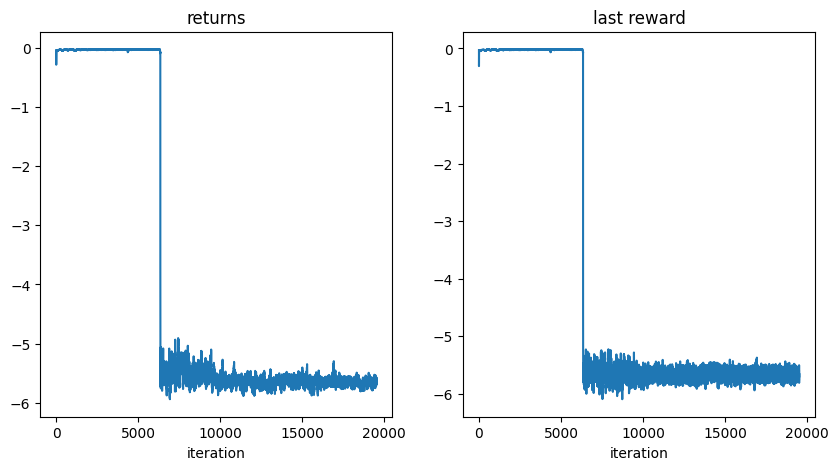

In [47]:
policy = TensorDictModule(
    net,
    in_keys=["thetas_sin", "thetas_cos", "target_pose"],#["on_manifold_error"], #["target_pose"],
    out_keys=["action"],
).cuda()
optim = torch.optim.Adam(policy.parameters(), lr=2e-3)
batch_size = 1024
iterations = 20000_000
pbar = tqdm.tqdm(range(iterations // batch_size))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, iterations)
logs = defaultdict(list)

# current_env = env 
current_env = transformed_env.cuda()

for _ in pbar:
    init_td = current_env.reset(current_env.gen_params(batch_size=[batch_size])).cuda()
    rollout = current_env.rollout(5, policy, tensordict=init_td, auto_reset=False).cuda()
    #print(rollout)
    traj_return = rollout["next", "reward"].mean()
    (-traj_return).backward()
    gn = torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
    optim.step()
    optim.zero_grad()
    pbar.set_description(
        f"reward: {traj_return: 4.4f}, "
        f"last reward: {rollout[..., -1]['next', 'reward'].mean(): 4.4f} / STD {rollout[..., -1]['next', 'reward'].std():4.4} / MIN {rollout[..., -1]['next', 'reward'].min():4.4} , gradient norm: {gn: 4.4}"        
    )
    logs["return"].append(traj_return.item())
    logs["last_reward"].append(rollout[..., -1]["next", "reward"].mean().item())
    scheduler.step()


def plot():
    import matplotlib
    from matplotlib import pyplot as plt

    is_ipython = "inline" in matplotlib.get_backend()
    if is_ipython:
        from IPython import display

    with plt.ion():
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(logs["return"])
        plt.title("returns")
        plt.xlabel("iteration")
        plt.subplot(1, 2, 2)
        plt.plot(logs["last_reward"])
        plt.title("last reward")
        plt.xlabel("iteration")
        if is_ipython:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        plt.show()


plot()
